## 非线性SVM

### 可视化数据集

In [1]:
import matplotlib.pyplot as plt
import numpy as np
 
def showDataSet(dataMat, labelMat):
    """
    数据可视化
    Parameters:
        dataMat - 数据矩阵
        labelMat - 数据标签
    Returns:
        无
    """
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)              #转换为numpy矩阵
    data_minus_np = np.array(data_minus)            #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1])   #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1]) #负样本散点图
    plt.show()
    
"""
函数说明:读取数据

Parameters:
    fileName - 文件名
Returns:
    dataMat - 数据矩阵
    labelMat - 数据标签
"""
def loadDataSet(fileName):
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():  # 逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])  # 添加数据
        labelMat.append(float(lineArr[2]))  # 添加标签
    return dataMat, labelMat

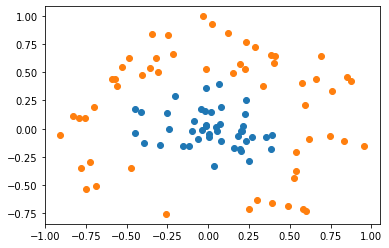

In [2]:
dataArr,labelArr = loadDataSet('testSetRBF.txt')       #加载训练集
showDataSet(dataArr, labelArr)

可见，数据明显是线性不可分的。下面我们根据公式，编写核函数，并增加初始化参数kTup用于存储核函数有关的信息，同时我们只要将之前的内积运算变成核函数的运算即可。最后编写testRbf()函数，用于测试。

### 利用核函数将数据映射到高维空间

In [3]:
import random

class optStruct:
    """
    数据结构，维护所有需要操作的值
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
        kTup - 包含核函数信息的元组,第一个参数存放核函数类别，第二个参数存放必要的核函数需要用到的参数
    """
    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        self.X = dataMatIn                                #数据矩阵
        self.labelMat = classLabels                        #数据标签
        self.C = C                                         #松弛变量
        self.tol = toler                                 #容错率
        self.m = np.shape(dataMatIn)[0]                 #数据矩阵行数
        self.alphas = np.mat(np.zeros((self.m,1)))         #根据矩阵行数初始化alpha参数为0   
        self.b = 0                                         #初始化b参数为0
        self.eCache = np.mat(np.zeros((self.m,2)))         #根据矩阵行数初始化虎误差缓存，第一列为是否有效的标志位，第二列为实际的误差E的值。
        self.K = np.mat(np.zeros((self.m,self.m)))        #初始化核K
        for i in range(self.m):                            #计算所有数据的核K
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)

def kernelTrans(X, A, kTup):
    """
    通过核函数将数据转换更高维的空间
    Parameters：
        X - 数据矩阵
        A - 单个数据的向量
        kTup - 包含核函数信息的元组
    Returns:
        K - 计算的核K
    """
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    if kTup[0] == 'lin': K = X * A.T     #线性核函数,只进行内积。
    elif kTup[0] == 'rbf':             #高斯核函数,根据高斯核函数公式进行计算
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = np.exp(K/(-1*kTup[1]**2))   #计算高斯核K
    elif kTup[0]=='exp':
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = np.sqrt(deltaRow*deltaRow.T)
        K = np.exp(K/(-1*kTup[1]**2))    #计算指数核
    elif kTup[0]=='lap':
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = np.sqrt(deltaRow*deltaRow.T)
        K = np.exp(K/(-1*kTup[1]))   #计算拉普拉斯核
    else: raise NameError('核函数无法识别')
    return K      #返回计算的核K

def calcEk(oS, k):
    """
    计算误差
    Parameters：
        oS - 数据结构
        k - 标号为k的数据
    Returns:
        Ek - 标号为k的数据误差
    """
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

"""
函数说明:随机选择alpha

Parameters:
    i - alpha
    m - alpha参数个数
Returns:
    j -
"""
def selectJrand(i, m):
    j = i  # 选择一个不等于i的j
    while (j == i):
        j = int(random.uniform(0, m))
    return j

"""
函数说明:修剪alpha

Parameters:
    aj - alpha值
    H - alpha上限
    L - alpha下限
Returns:
    aj - alpah值
"""
def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj


def selectJ(i, oS, Ei):
    """
    内循环启发方式2
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
        Ei - 标号为i的数据误差
    Returns:
        j, maxK - 标号为j或maxK的数据的索引值
        Ej - 标号为j的数据误差
    """
    maxK = -1; maxDeltaE = 0; Ej = 0                         #初始化
    oS.eCache[i] = [1,Ei]                                      #根据Ei更新误差缓存
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]        #返回误差不为0的数据的索引值
    if (len(validEcacheList)) > 1:                            #有不为0的误差
        for k in validEcacheList:                           #遍历,找到最大的Ek
            if k == i: continue                             #不计算i,浪费时间
            Ek = calcEk(oS, k)                                #计算Ek
            deltaE = abs(Ei - Ek)                            #计算|Ei-Ek|
            if (deltaE > maxDeltaE):                        #找到maxDeltaE
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej                                        #返回maxK,Ej
    else:                                                   #没有不为0的误差
        j = selectJrand(i, oS.m)                            #随机选择alpha_j的索引值
        Ej = calcEk(oS, j)                                    #计算Ej
    return j, Ej                                             #j,Ej

def updateEk(oS, k):
    """
    计算Ek,并更新误差缓存
    Parameters：
        oS - 数据结构
        k - 标号为k的数据的索引值
    Returns:
        无
    """
    Ek = calcEk(oS, k)                                        #计算Ek
    oS.eCache[k] = [1,Ek]                                    #更新误差缓存

def innerL(i, oS):
    """
    优化的SMO算法
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
    Returns:
        1 - 有任意一对alpha值发生变化
        0 - 没有任意一对alpha值发生变化或变化太小
    """
    #步骤1：计算误差Ei
    Ei = calcEk(oS, i)
    #优化alpha,设定一定的容错率。
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        #使用内循环启发方式2选择alpha_j,并计算Ej
        j,Ej = selectJ(i, oS, Ei)
        #保存更新前的aplpha值，使用深拷贝
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        #步骤2：计算上下界L和H
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print("L==H")
            return 0
        #步骤3：计算eta
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j]
        if eta >= 0:
            print("eta>=0")
            return 0
        #步骤4：更新alpha_j
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej)/eta
        #步骤5：修剪alpha_j
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        #更新Ej至误差缓存
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("alpha_j变化太小")
            return 0
        #步骤6：更新alpha_i
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        #步骤8：根据b_1和b_2更新b
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else:
        return 0

def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup = ('lin',0)):
    """
    完整的线性SMO算法
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
        maxIter - 最大迭代次数
        kTup - 包含核函数信息的元组
    Returns:
        oS.b - SMO算法计算的b
        oS.alphas - SMO算法计算的alphas
    """
    oS = optStruct(np.mat(dataMatIn), np.mat(classLabels).transpose(), C, toler, kTup)                #初始化数据结构
    iter = 0                                                                                         #初始化当前迭代次数
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):                            #遍历整个数据集alpha也没有更新或者超过最大迭代次数,则退出循环
        alphaPairsChanged = 0
        if entireSet:                                                                                #遍历整个数据集                           
            for i in range(oS.m):       
                alphaPairsChanged += innerL(i,oS)                                                    #使用优化的SMO算法
                print("全样本遍历，第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:                                                                                         #遍历非边界值
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]                        #遍历不在边界0和C的alpha
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("非边界遍历，第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet:                                                                                #遍历一次后改为非边界遍历
            entireSet = False
        elif (alphaPairsChanged == 0):                                                                #如果alpha没有更新,计算全样本遍历
            entireSet = True 
        print("迭代次数: %d" % iter)
    return oS.b,oS.alphas                                                                             #返回SMO算法计算的b和alphas

def testRbf(k1 = 1.3):
    """
    测试函数
    Parameters:
        k1 - 使用高斯核函数的时候表示到达率
    Returns:
        无
    """
    dataArr,labelArr = loadDataSet('testSetRBF.txt')                        #加载训练集
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 100, ('rbf', k1))        #根据训练集计算b和alphas
    datMat = np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    svInd = np.nonzero(alphas.A > 0)[0]                                        #获得支持向量
    sVs = datMat[svInd]                                                     
    labelSV = labelMat[svInd];
    print("the number of support vectors:%d" % np.shape(sVs)[0])
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))                #计算各个点的核
        predict = kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b     #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]): errorCount += 1        #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("the error rate of training set: %f" % ((float(errorCount)/m)))             #打印错误率
    dataArr,labelArr = loadDataSet('testSetRBF2.txt')                         #加载测试集
    errorCount = 0
    datMat = np.mat(dataArr); labelMat = np.mat(labelArr).transpose()         
    m,n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))                 #计算各个点的核           
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b         #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]): 
            errorCount += 1        #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("the error rate of testing set: %f" % ((float(errorCount)/m)))             #打印错误率


In [4]:
testRbf()

L==H
全样本遍历，第0次迭代 样本:0, alpha优化次数:0
全样本遍历，第0次迭代 样本:1, alpha优化次数:1
全样本遍历，第0次迭代 样本:2, alpha优化次数:2
全样本遍历，第0次迭代 样本:3, alpha优化次数:3
全样本遍历，第0次迭代 样本:4, alpha优化次数:3
全样本遍历，第0次迭代 样本:5, alpha优化次数:4
全样本遍历，第0次迭代 样本:6, alpha优化次数:5
全样本遍历，第0次迭代 样本:7, alpha优化次数:5
全样本遍历，第0次迭代 样本:8, alpha优化次数:6
全样本遍历，第0次迭代 样本:9, alpha优化次数:6
全样本遍历，第0次迭代 样本:10, alpha优化次数:7
全样本遍历，第0次迭代 样本:11, alpha优化次数:8
alpha_j变化太小
全样本遍历，第0次迭代 样本:12, alpha优化次数:8
全样本遍历，第0次迭代 样本:13, alpha优化次数:9
全样本遍历，第0次迭代 样本:14, alpha优化次数:10
全样本遍历，第0次迭代 样本:15, alpha优化次数:11
全样本遍历，第0次迭代 样本:16, alpha优化次数:12
全样本遍历，第0次迭代 样本:17, alpha优化次数:13
全样本遍历，第0次迭代 样本:18, alpha优化次数:14
全样本遍历，第0次迭代 样本:19, alpha优化次数:15
全样本遍历，第0次迭代 样本:20, alpha优化次数:15
全样本遍历，第0次迭代 样本:21, alpha优化次数:16
alpha_j变化太小
全样本遍历，第0次迭代 样本:22, alpha优化次数:16
全样本遍历，第0次迭代 样本:23, alpha优化次数:17
全样本遍历，第0次迭代 样本:24, alpha优化次数:18
全样本遍历，第0次迭代 样本:25, alpha优化次数:18
全样本遍历，第0次迭代 样本:26, alpha优化次数:19
全样本遍历，第0次迭代 样本:27, alpha优化次数:20
全样本遍历，第0次迭代 样本:28, alpha优化次数:21
alpha_j变化太小
全样本遍历，第0次迭代 样本:29, alpha优化次数:21
全样本遍历，第0次迭代 样本:30, alph

可以看到，训练集错误率为1%，测试集错误率都是4%，训练耗时1.7s 。可以尝试更换不同的K1参数以观察测试错误率、训练错误率、支持向量个数随k1的变化情况。你会发现K1过大，会出现过拟合的情况，即训练集错误率低，但是测试集错误率高。 简言之，对于固定的数据集，支持向量的数目存在一个最优值，如果支持向量太少，会得到一个很差的决策边界；而支持向量太多，也相当于利用整个数据集进行分类，就类似于KNN算法，显然运算速度不高。

In [5]:
testRbf(4)

L==H
全样本遍历，第0次迭代 样本:0, alpha优化次数:0
全样本遍历，第0次迭代 样本:1, alpha优化次数:1
全样本遍历，第0次迭代 样本:2, alpha优化次数:2
全样本遍历，第0次迭代 样本:3, alpha优化次数:3
全样本遍历，第0次迭代 样本:4, alpha优化次数:3
全样本遍历，第0次迭代 样本:5, alpha优化次数:4
全样本遍历，第0次迭代 样本:6, alpha优化次数:4
全样本遍历，第0次迭代 样本:7, alpha优化次数:4
全样本遍历，第0次迭代 样本:8, alpha优化次数:5
全样本遍历，第0次迭代 样本:9, alpha优化次数:5
全样本遍历，第0次迭代 样本:10, alpha优化次数:6
全样本遍历，第0次迭代 样本:11, alpha优化次数:7
全样本遍历，第0次迭代 样本:12, alpha优化次数:8
全样本遍历，第0次迭代 样本:13, alpha优化次数:9
全样本遍历，第0次迭代 样本:14, alpha优化次数:10
全样本遍历，第0次迭代 样本:15, alpha优化次数:11
全样本遍历，第0次迭代 样本:16, alpha优化次数:12
alpha_j变化太小
全样本遍历，第0次迭代 样本:17, alpha优化次数:12
全样本遍历，第0次迭代 样本:18, alpha优化次数:13
全样本遍历，第0次迭代 样本:19, alpha优化次数:14
全样本遍历，第0次迭代 样本:20, alpha优化次数:15
全样本遍历，第0次迭代 样本:21, alpha优化次数:16
全样本遍历，第0次迭代 样本:22, alpha优化次数:17
全样本遍历，第0次迭代 样本:23, alpha优化次数:17
alpha_j变化太小
全样本遍历，第0次迭代 样本:24, alpha优化次数:17
alpha_j变化太小
全样本遍历，第0次迭代 样本:25, alpha优化次数:17
全样本遍历，第0次迭代 样本:26, alpha优化次数:18
全样本遍历，第0次迭代 样本:27, alpha优化次数:18
全样本遍历，第0次迭代 样本:28, alpha优化次数:19
全样本遍历，第0次迭代 样本:29, alpha优化次数:20
L==H
全样本遍历，第0次迭代 样本:30,

the error rate of training set: 0.210000
the error rate of testing set: 0.380000


在优化的过程中，我们仅仅需要找到支持向量和其对应的alpha值，而对于其他的样本值可以不用管，甚至可以舍弃，因为这些样本将不会对分类预测函数造成任何影响。这也就是SVM相比KNN算法的优秀的地方所在

### 手写数字识别

相较于KNN算法，尽管KNN也能取得不错的效果；但是从节省内存的角度出发，显然SVM算法更胜一筹，因为其不需要保存真个数据集，而只需要其作用的支持向量点，而取得不错的分类效果。

In [6]:
def loadImages(dirName):
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)
    m = len(trainingFileList)
    trainingMat = np.zeros((m, 1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9:
            hwLabels.append(-1)
        else:
            hwLabels.append(1)
        trainingMat[i, :] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels

# 将图像转为向量
def img2vector(filename):
    returnVect = np.zeros((1, 1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0, 32*i+j] = int(lineStr[j])
    return returnVect

In [7]:
# 利用svm测试数字
def testDigits(kTup=('rbf', 10)):
    # 训练集
    dataArr, labelArr = loadImages('trainingDigits')
    b, alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    dataMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    svInd = np.nonzero(alphas.A > 0)[0]
    sVs = dataMat[svInd]
    labelSV = labelMat[svInd]
    print("there are %d Support Vectors" % np.shape(sVs)[0])
    m, n = np.shape(dataMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, dataMat[i, :], kTup)
        predict = kernelEval.T*np.multiply(labelSV, alphas[svInd])+b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1
    print("the training error rate is: %f" % (float(errorCount)/m))
    # 测试集
    dataArr, labelArr = loadImages('testDigits')
    dataMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    errorCount = 0
    m, n = np.shape(dataMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs, dataMat[i, :],kTup)
        predict = kernelEval.T * (np.multiply(labelSV, alphas[svInd]))+b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1
    print("the tesing error rate is: %f" % (float(errorCount)/m))

In [8]:
testDigits()

L==H
全样本遍历，第0次迭代 样本:0, alpha优化次数:0
全样本遍历，第0次迭代 样本:1, alpha优化次数:1
全样本遍历，第0次迭代 样本:2, alpha优化次数:2
全样本遍历，第0次迭代 样本:3, alpha优化次数:3
全样本遍历，第0次迭代 样本:4, alpha优化次数:4
全样本遍历，第0次迭代 样本:5, alpha优化次数:5
全样本遍历，第0次迭代 样本:6, alpha优化次数:6
全样本遍历，第0次迭代 样本:7, alpha优化次数:7
全样本遍历，第0次迭代 样本:8, alpha优化次数:8
全样本遍历，第0次迭代 样本:9, alpha优化次数:9
全样本遍历，第0次迭代 样本:10, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:11, alpha优化次数:10
全样本遍历，第0次迭代 样本:12, alpha优化次数:11
全样本遍历，第0次迭代 样本:13, alpha优化次数:12
全样本遍历，第0次迭代 样本:14, alpha优化次数:13
全样本遍历，第0次迭代 样本:15, alpha优化次数:14
全样本遍历，第0次迭代 样本:16, alpha优化次数:15
全样本遍历，第0次迭代 样本:17, alpha优化次数:16
alpha_j变化太小
全样本遍历，第0次迭代 样本:18, alpha优化次数:16
全样本遍历，第0次迭代 样本:19, alpha优化次数:17
全样本遍历，第0次迭代 样本:20, alpha优化次数:18
全样本遍历，第0次迭代 样本:21, alpha优化次数:19
全样本遍历，第0次迭代 样本:22, alpha优化次数:20
全样本遍历，第0次迭代 样本:23, alpha优化次数:20
全样本遍历，第0次迭代 样本:24, alpha优化次数:20
全样本遍历，第0次迭代 样本:25, alpha优化次数:20
全样本遍历，第0次迭代 样本:26, alpha优化次数:20
全样本遍历，第0次迭代 样本:27, alpha优化次数:20
全样本遍历，第0次迭代 样本:28, alpha优化次数:20
全样本遍历，第0次迭代 样本:29, alpha优化次数:20
全样本遍历，第0次迭代 样本:30, alpha优化次数:20
全样本遍历，

L==H
全样本遍历，第0次迭代 样本:296, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:297, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:298, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:299, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:300, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:301, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:302, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:303, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:304, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:305, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:306, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:307, alpha优化次数:79
全样本遍历，第0次迭代 样本:308, alpha优化次数:79
全样本遍历，第0次迭代 样本:309, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:310, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:311, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:312, alpha优化次数:79
全样本遍历，第0次迭代 样本:313, alpha优化次数:79
全样本遍历，第0次迭代 样本:314, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:315, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:316, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:317, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:318, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:319, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:320, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:321, alpha优化次数:79
L==H
全样本遍历，第0次迭代 样本:322, alpha优化

alpha_j变化太小
非边界遍历，第2次迭代 样本:199, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:204, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:205, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:207, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:208, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:210, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:215, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:218, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:226, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:230, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:232, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:234, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:235, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:236, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:238, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:242, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:243, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:245, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:246, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:249, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:252, alpha优化次数:15
alpha_j变化太小
非边界遍历，第2次迭代 样本:253, alpha优化次数:15
alpha_j变化太

L==H
全样本遍历，第4次迭代 样本:0, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:1, alpha优化次数:0
全样本遍历，第4次迭代 样本:2, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:3, alpha优化次数:0
全样本遍历，第4次迭代 样本:4, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:5, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:6, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:7, alpha优化次数:0
L==H
全样本遍历，第4次迭代 样本:8, alpha优化次数:0
全样本遍历，第4次迭代 样本:9, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:10, alpha优化次数:0
L==H
全样本遍历，第4次迭代 样本:11, alpha优化次数:0
L==H
全样本遍历，第4次迭代 样本:12, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:13, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:14, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:15, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:16, alpha优化次数:0
全样本遍历，第4次迭代 样本:17, alpha优化次数:0
L==H
全样本遍历，第4次迭代 样本:18, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:19, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:20, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:21, alpha优化次数:0
alpha_j变化太小
全样本遍历，第4次迭代 样本:22, alpha优化次数:0
L==H
全样本遍历，第4次迭代 样本:23, alpha优化次数:0
全样本遍历，第4次迭代 样本:24, alpha优化次数:0
全样本遍历，第4次迭代 样本:25, alpha优化次数:0
全样本遍历，

全样本遍历，第4次迭代 样本:253, alpha优化次数:4
alpha_j变化太小
全样本遍历，第4次迭代 样本:254, alpha优化次数:4
alpha_j变化太小
全样本遍历，第4次迭代 样本:255, alpha优化次数:4
全样本遍历，第4次迭代 样本:256, alpha优化次数:5
alpha_j变化太小
全样本遍历，第4次迭代 样本:257, alpha优化次数:5
L==H
全样本遍历，第4次迭代 样本:258, alpha优化次数:5
alpha_j变化太小
全样本遍历，第4次迭代 样本:259, alpha优化次数:5
L==H
全样本遍历，第4次迭代 样本:260, alpha优化次数:5
全样本遍历，第4次迭代 样本:261, alpha优化次数:5
alpha_j变化太小
全样本遍历，第4次迭代 样本:262, alpha优化次数:5
全样本遍历，第4次迭代 样本:263, alpha优化次数:5
alpha_j变化太小
全样本遍历，第4次迭代 样本:264, alpha优化次数:5
全样本遍历，第4次迭代 样本:265, alpha优化次数:5
alpha_j变化太小
全样本遍历，第4次迭代 样本:266, alpha优化次数:5
全样本遍历，第4次迭代 样本:267, alpha优化次数:5
全样本遍历，第4次迭代 样本:268, alpha优化次数:5
全样本遍历，第4次迭代 样本:269, alpha优化次数:5
alpha_j变化太小
全样本遍历，第4次迭代 样本:270, alpha优化次数:5
alpha_j变化太小
全样本遍历，第4次迭代 样本:271, alpha优化次数:5
全样本遍历，第4次迭代 样本:272, alpha优化次数:5
全样本遍历，第4次迭代 样本:273, alpha优化次数:5
alpha_j变化太小
全样本遍历，第4次迭代 样本:274, alpha优化次数:5
alpha_j变化太小
全样本遍历，第4次迭代 样本:275, alpha优化次数:5
全样本遍历，第4次迭代 样本:276, alpha优化次数:5
alpha_j变化太小
全样本遍历，第4次迭代 样本:277, alpha优化次数:5
alpha_j变化太小
全样本遍历，第4次迭代 样本:278, alpha优化次数:5
全样

alpha_j变化太小
非边界遍历，第5次迭代 样本:218, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:226, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:230, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:232, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:234, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:235, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:236, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:238, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:242, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:243, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:245, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:246, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:249, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:250, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:252, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:253, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:254, alpha优化次数:0
非边界遍历，第5次迭代 样本:256, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:259, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:271, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:275, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:277, alpha优化次数:0
alpha_j变化太小
非边界遍历，第5次迭代 样本:284, alpha优化次数:0


L==H
全样本遍历，第6次迭代 样本:177, alpha优化次数:0
L==H
全样本遍历，第6次迭代 样本:178, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:179, alpha优化次数:0
L==H
全样本遍历，第6次迭代 样本:180, alpha优化次数:0
全样本遍历，第6次迭代 样本:181, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:182, alpha优化次数:0
L==H
全样本遍历，第6次迭代 样本:183, alpha优化次数:0
全样本遍历，第6次迭代 样本:184, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:185, alpha优化次数:0
L==H
全样本遍历，第6次迭代 样本:186, alpha优化次数:0
全样本遍历，第6次迭代 样本:187, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:188, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:189, alpha优化次数:0
全样本遍历，第6次迭代 样本:190, alpha优化次数:0
全样本遍历，第6次迭代 样本:191, alpha优化次数:0
全样本遍历，第6次迭代 样本:192, alpha优化次数:0
全样本遍历，第6次迭代 样本:193, alpha优化次数:0
全样本遍历，第6次迭代 样本:194, alpha优化次数:0
L==H
全样本遍历，第6次迭代 样本:195, alpha优化次数:0
全样本遍历，第6次迭代 样本:196, alpha优化次数:0
L==H
全样本遍历，第6次迭代 样本:197, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:198, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:199, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:200, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:201, alpha优化次数:0
全样本遍历，第6次迭代 样本:202, alpha优化次数:0
全样本遍历，第6次迭代 样本:203, alpha

L==H
全样本遍历，第6次迭代 样本:397, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:398, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:399, alpha优化次数:0
全样本遍历，第6次迭代 样本:400, alpha优化次数:0
alpha_j变化太小
全样本遍历，第6次迭代 样本:401, alpha优化次数:0
迭代次数: 7
there are 131 Support Vectors
the training error rate is: 0.000000
the tesing error rate is: 0.005376


In [9]:
testDigits(kTup=('rbf', 20))

全样本遍历，第0次迭代 样本:0, alpha优化次数:1
全样本遍历，第0次迭代 样本:1, alpha优化次数:2
全样本遍历，第0次迭代 样本:2, alpha优化次数:3
全样本遍历，第0次迭代 样本:3, alpha优化次数:4
全样本遍历，第0次迭代 样本:4, alpha优化次数:5
全样本遍历，第0次迭代 样本:5, alpha优化次数:6
全样本遍历，第0次迭代 样本:6, alpha优化次数:6
全样本遍历，第0次迭代 样本:7, alpha优化次数:7
全样本遍历，第0次迭代 样本:8, alpha优化次数:8
全样本遍历，第0次迭代 样本:9, alpha优化次数:8
全样本遍历，第0次迭代 样本:10, alpha优化次数:9
全样本遍历，第0次迭代 样本:11, alpha优化次数:9
全样本遍历，第0次迭代 样本:12, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:13, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:14, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:15, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:16, alpha优化次数:10
全样本遍历，第0次迭代 样本:17, alpha优化次数:10
全样本遍历，第0次迭代 样本:18, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:19, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:20, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:21, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:22, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:23, alpha优化次数:10
全样本遍历，第0次迭代 样本:24, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:25, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:26, alpha优化次数:10
全样本遍历，第0次迭代 样本:27, alpha优化次数:10
全样本遍历，第0次迭代 样本:28, alpha优化次数:10
全样本遍历，第0次迭代 样本:29, alpha优化次数:10
L==H
全样

L==H
全样本遍历，第0次迭代 样本:233, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:234, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:235, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:236, alpha优化次数:23
全样本遍历，第0次迭代 样本:237, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:238, alpha优化次数:23
alpha_j变化太小
全样本遍历，第0次迭代 样本:239, alpha优化次数:23
全样本遍历，第0次迭代 样本:240, alpha优化次数:23
全样本遍历，第0次迭代 样本:241, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:242, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:243, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:244, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:245, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:246, alpha优化次数:23
全样本遍历，第0次迭代 样本:247, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:248, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:249, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:250, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:251, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:252, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:253, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:254, alpha优化次数:23
全样本遍历，第0次迭代 样本:255, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:256, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:257, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:258, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:259, alpha

alpha_j变化太小
非边界遍历，第2次迭代 样本:208, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:209, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:210, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:211, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:249, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:284, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:287, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:311, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:317, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:319, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:323, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:330, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:332, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:337, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:362, alpha优化次数:0
迭代次数: 3
alpha_j变化太小
全样本遍历，第3次迭代 样本:0, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:1, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:2, alpha优化次数:0
全样本遍历，第3次迭代 样本:3, alpha优化次数:0
全样本遍历，第3次迭代 样本:4, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:5, alpha优化次数:0
全样本遍历，第3次迭代 样本:6, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:7, alpha优化次数:0
全样本遍历，第3次迭代 样本:8, alpha优化次数:0
全样

alpha_j变化太小
全样本遍历，第3次迭代 样本:262, alpha优化次数:0
全样本遍历，第3次迭代 样本:263, alpha优化次数:0
全样本遍历，第3次迭代 样本:264, alpha优化次数:0
全样本遍历，第3次迭代 样本:265, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:266, alpha优化次数:0
全样本遍历，第3次迭代 样本:267, alpha优化次数:0
全样本遍历，第3次迭代 样本:268, alpha优化次数:0
全样本遍历，第3次迭代 样本:269, alpha优化次数:0
全样本遍历，第3次迭代 样本:270, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:271, alpha优化次数:0
全样本遍历，第3次迭代 样本:272, alpha优化次数:0
全样本遍历，第3次迭代 样本:273, alpha优化次数:0
全样本遍历，第3次迭代 样本:274, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:275, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:276, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:277, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:278, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:279, alpha优化次数:0
全样本遍历，第3次迭代 样本:280, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:281, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:282, alpha优化次数:0
全样本遍历，第3次迭代 样本:283, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:284, alpha优化次数:0
全样本遍历，第3次迭代 样本:285, alpha优化次数:0
全样本遍历，第3次迭代 样本:286, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:287, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:288,

In [10]:
testDigits(kTup=('rbf', 50))

L==H
全样本遍历，第0次迭代 样本:0, alpha优化次数:0
全样本遍历，第0次迭代 样本:1, alpha优化次数:1
全样本遍历，第0次迭代 样本:2, alpha优化次数:2
全样本遍历，第0次迭代 样本:3, alpha优化次数:3
全样本遍历，第0次迭代 样本:4, alpha优化次数:3
全样本遍历，第0次迭代 样本:5, alpha优化次数:4
全样本遍历，第0次迭代 样本:6, alpha优化次数:4
全样本遍历，第0次迭代 样本:7, alpha优化次数:5
全样本遍历，第0次迭代 样本:8, alpha优化次数:5
全样本遍历，第0次迭代 样本:9, alpha优化次数:5
全样本遍历，第0次迭代 样本:10, alpha优化次数:5
全样本遍历，第0次迭代 样本:11, alpha优化次数:5
全样本遍历，第0次迭代 样本:12, alpha优化次数:6
全样本遍历，第0次迭代 样本:13, alpha优化次数:7
全样本遍历，第0次迭代 样本:14, alpha优化次数:7
全样本遍历，第0次迭代 样本:15, alpha优化次数:7
全样本遍历，第0次迭代 样本:16, alpha优化次数:7
全样本遍历，第0次迭代 样本:17, alpha优化次数:7
全样本遍历，第0次迭代 样本:18, alpha优化次数:7
全样本遍历，第0次迭代 样本:19, alpha优化次数:8
全样本遍历，第0次迭代 样本:20, alpha优化次数:9
全样本遍历，第0次迭代 样本:21, alpha优化次数:10
全样本遍历，第0次迭代 样本:22, alpha优化次数:11
全样本遍历，第0次迭代 样本:23, alpha优化次数:11
全样本遍历，第0次迭代 样本:24, alpha优化次数:11
全样本遍历，第0次迭代 样本:25, alpha优化次数:11
全样本遍历，第0次迭代 样本:26, alpha优化次数:11
全样本遍历，第0次迭代 样本:27, alpha优化次数:11
全样本遍历，第0次迭代 样本:28, alpha优化次数:11
全样本遍历，第0次迭代 样本:29, alpha优化次数:11
全样本遍历，第0次迭代 样本:30, alpha优化次数:11
全样本遍历，第0次迭代 样本:31, alpha优化次数:11
全样

L==H
全样本遍历，第0次迭代 样本:270, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:271, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:272, alpha优化次数:22
全样本遍历，第0次迭代 样本:273, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:274, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:275, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:276, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:277, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:278, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:279, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:280, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:281, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:282, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:283, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:284, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:285, alpha优化次数:22
全样本遍历，第0次迭代 样本:286, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:287, alpha优化次数:22
全样本遍历，第0次迭代 样本:288, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:289, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:290, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:291, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:292, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:293, alpha优化次数:22
全样本遍历，第0次迭代 样本:294, alpha优化次数:22
全样本遍历，第0次迭代 样本:295, alpha优化次数:22
L==H
全样本遍历，第0次迭代 样本:296, alpha优化次数:22

全样本遍历，第3次迭代 样本:136, alpha优化次数:4
全样本遍历，第3次迭代 样本:137, alpha优化次数:4
全样本遍历，第3次迭代 样本:138, alpha优化次数:4
全样本遍历，第3次迭代 样本:139, alpha优化次数:4
全样本遍历，第3次迭代 样本:140, alpha优化次数:4
全样本遍历，第3次迭代 样本:141, alpha优化次数:4
全样本遍历，第3次迭代 样本:142, alpha优化次数:4
全样本遍历，第3次迭代 样本:143, alpha优化次数:4
全样本遍历，第3次迭代 样本:144, alpha优化次数:4
全样本遍历，第3次迭代 样本:145, alpha优化次数:4
全样本遍历，第3次迭代 样本:146, alpha优化次数:4
全样本遍历，第3次迭代 样本:147, alpha优化次数:4
全样本遍历，第3次迭代 样本:148, alpha优化次数:4
全样本遍历，第3次迭代 样本:149, alpha优化次数:4
全样本遍历，第3次迭代 样本:150, alpha优化次数:4
全样本遍历，第3次迭代 样本:151, alpha优化次数:4
全样本遍历，第3次迭代 样本:152, alpha优化次数:4
全样本遍历，第3次迭代 样本:153, alpha优化次数:4
全样本遍历，第3次迭代 样本:154, alpha优化次数:4
全样本遍历，第3次迭代 样本:155, alpha优化次数:4
全样本遍历，第3次迭代 样本:156, alpha优化次数:4
全样本遍历，第3次迭代 样本:157, alpha优化次数:4
全样本遍历，第3次迭代 样本:158, alpha优化次数:4
全样本遍历，第3次迭代 样本:159, alpha优化次数:4
全样本遍历，第3次迭代 样本:160, alpha优化次数:4
全样本遍历，第3次迭代 样本:161, alpha优化次数:4
alpha_j变化太小
全样本遍历，第3次迭代 样本:162, alpha优化次数:4
全样本遍历，第3次迭代 样本:163, alpha优化次数:4
全样本遍历，第3次迭代 样本:164, alpha优化次数:4
全样本遍历，第3次迭代 样本:165, alpha优化次数:4
全样本遍历，第3次迭代 样本:166, alpha优化次

非边界遍历，第4次迭代 样本:105, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:117, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:125, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:127, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:130, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:162, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:198, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:199, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:200, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:203, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:204, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:205, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:207, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:208, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:209, alpha优化次数:0
非边界遍历，第4次迭代 样本:215, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:284, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:287, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:311, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:317, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:332, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:337, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:401, alpha优化次数:0
迭代次数: 5
全样本遍

alpha_j变化太小
全样本遍历，第5次迭代 样本:245, alpha优化次数:0
全样本遍历，第5次迭代 样本:246, alpha优化次数:0
全样本遍历，第5次迭代 样本:247, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:248, alpha优化次数:0
L==H
全样本遍历，第5次迭代 样本:249, alpha优化次数:0
L==H
全样本遍历，第5次迭代 样本:250, alpha优化次数:0
全样本遍历，第5次迭代 样本:251, alpha优化次数:0
全样本遍历，第5次迭代 样本:252, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:253, alpha优化次数:0
L==H
全样本遍历，第5次迭代 样本:254, alpha优化次数:0
全样本遍历，第5次迭代 样本:255, alpha优化次数:0
全样本遍历，第5次迭代 样本:256, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:257, alpha优化次数:0
全样本遍历，第5次迭代 样本:258, alpha优化次数:0
L==H
全样本遍历，第5次迭代 样本:259, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:260, alpha优化次数:0
全样本遍历，第5次迭代 样本:261, alpha优化次数:0
全样本遍历，第5次迭代 样本:262, alpha优化次数:0
全样本遍历，第5次迭代 样本:263, alpha优化次数:0
全样本遍历，第5次迭代 样本:264, alpha优化次数:0
全样本遍历，第5次迭代 样本:265, alpha优化次数:0
全样本遍历，第5次迭代 样本:266, alpha优化次数:0
全样本遍历，第5次迭代 样本:267, alpha优化次数:0
全样本遍历，第5次迭代 样本:268, alpha优化次数:0
全样本遍历，第5次迭代 样本:269, alpha优化次数:0
全样本遍历，第5次迭代 样本:270, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:271, alpha优化次数:0
全样本遍历，第5次迭代 样本:272, alpha优化次数:0
全样本遍历，第5次迭代 

In [11]:
testDigits(kTup=('rbf', 0.1))

全样本遍历，第0次迭代 样本:0, alpha优化次数:1
全样本遍历，第0次迭代 样本:1, alpha优化次数:2
全样本遍历，第0次迭代 样本:2, alpha优化次数:3
全样本遍历，第0次迭代 样本:3, alpha优化次数:4
全样本遍历，第0次迭代 样本:4, alpha优化次数:5
全样本遍历，第0次迭代 样本:5, alpha优化次数:6
全样本遍历，第0次迭代 样本:6, alpha优化次数:7
全样本遍历，第0次迭代 样本:7, alpha优化次数:8
全样本遍历，第0次迭代 样本:8, alpha优化次数:9
全样本遍历，第0次迭代 样本:9, alpha优化次数:10
全样本遍历，第0次迭代 样本:10, alpha优化次数:11
全样本遍历，第0次迭代 样本:11, alpha优化次数:12
全样本遍历，第0次迭代 样本:12, alpha优化次数:13
全样本遍历，第0次迭代 样本:13, alpha优化次数:14
全样本遍历，第0次迭代 样本:14, alpha优化次数:15
全样本遍历，第0次迭代 样本:15, alpha优化次数:16
全样本遍历，第0次迭代 样本:16, alpha优化次数:17
全样本遍历，第0次迭代 样本:17, alpha优化次数:18
全样本遍历，第0次迭代 样本:18, alpha优化次数:19
全样本遍历，第0次迭代 样本:19, alpha优化次数:20
全样本遍历，第0次迭代 样本:20, alpha优化次数:21
全样本遍历，第0次迭代 样本:21, alpha优化次数:22
全样本遍历，第0次迭代 样本:22, alpha优化次数:23
全样本遍历，第0次迭代 样本:23, alpha优化次数:24
全样本遍历，第0次迭代 样本:24, alpha优化次数:25
全样本遍历，第0次迭代 样本:25, alpha优化次数:26
全样本遍历，第0次迭代 样本:26, alpha优化次数:27
全样本遍历，第0次迭代 样本:27, alpha优化次数:28
全样本遍历，第0次迭代 样本:28, alpha优化次数:29
全样本遍历，第0次迭代 样本:29, alpha优化次数:30
全样本遍历，第0次迭代 样本:30, alpha优化次数:31
全样本遍历，第0次迭代 样本:31, alpha优化次

全样本遍历，第0次迭代 样本:275, alpha优化次数:276
全样本遍历，第0次迭代 样本:276, alpha优化次数:277
全样本遍历，第0次迭代 样本:277, alpha优化次数:278
全样本遍历，第0次迭代 样本:278, alpha优化次数:279
全样本遍历，第0次迭代 样本:279, alpha优化次数:280
全样本遍历，第0次迭代 样本:280, alpha优化次数:281
全样本遍历，第0次迭代 样本:281, alpha优化次数:282
全样本遍历，第0次迭代 样本:282, alpha优化次数:283
全样本遍历，第0次迭代 样本:283, alpha优化次数:284
全样本遍历，第0次迭代 样本:284, alpha优化次数:285
全样本遍历，第0次迭代 样本:285, alpha优化次数:286
全样本遍历，第0次迭代 样本:286, alpha优化次数:287
全样本遍历，第0次迭代 样本:287, alpha优化次数:288
全样本遍历，第0次迭代 样本:288, alpha优化次数:289
全样本遍历，第0次迭代 样本:289, alpha优化次数:290
全样本遍历，第0次迭代 样本:290, alpha优化次数:291
全样本遍历，第0次迭代 样本:291, alpha优化次数:292
全样本遍历，第0次迭代 样本:292, alpha优化次数:293
全样本遍历，第0次迭代 样本:293, alpha优化次数:294
全样本遍历，第0次迭代 样本:294, alpha优化次数:295
全样本遍历，第0次迭代 样本:295, alpha优化次数:296
全样本遍历，第0次迭代 样本:296, alpha优化次数:297
全样本遍历，第0次迭代 样本:297, alpha优化次数:298
全样本遍历，第0次迭代 样本:298, alpha优化次数:299
全样本遍历，第0次迭代 样本:299, alpha优化次数:300
全样本遍历，第0次迭代 样本:300, alpha优化次数:301
全样本遍历，第0次迭代 样本:301, alpha优化次数:302
全样本遍历，第0次迭代 样本:302, alpha优化次数:303
全样本遍历，第0次迭代 样本:303, alpha优化次数:304
全样本遍历，第0次迭代 样本

非边界遍历，第1次迭代 样本:134, alpha优化次数:132
非边界遍历，第1次迭代 样本:135, alpha优化次数:133
非边界遍历，第1次迭代 样本:136, alpha优化次数:134
非边界遍历，第1次迭代 样本:137, alpha优化次数:135
非边界遍历，第1次迭代 样本:138, alpha优化次数:136
非边界遍历，第1次迭代 样本:139, alpha优化次数:137
非边界遍历，第1次迭代 样本:140, alpha优化次数:138
非边界遍历，第1次迭代 样本:141, alpha优化次数:139
非边界遍历，第1次迭代 样本:142, alpha优化次数:140
非边界遍历，第1次迭代 样本:143, alpha优化次数:141
非边界遍历，第1次迭代 样本:144, alpha优化次数:142
非边界遍历，第1次迭代 样本:145, alpha优化次数:143
非边界遍历，第1次迭代 样本:146, alpha优化次数:144
非边界遍历，第1次迭代 样本:147, alpha优化次数:145
非边界遍历，第1次迭代 样本:148, alpha优化次数:146
非边界遍历，第1次迭代 样本:149, alpha优化次数:147
非边界遍历，第1次迭代 样本:150, alpha优化次数:148
非边界遍历，第1次迭代 样本:151, alpha优化次数:149
非边界遍历，第1次迭代 样本:152, alpha优化次数:150
非边界遍历，第1次迭代 样本:153, alpha优化次数:151
非边界遍历，第1次迭代 样本:154, alpha优化次数:152
非边界遍历，第1次迭代 样本:155, alpha优化次数:153
非边界遍历，第1次迭代 样本:156, alpha优化次数:154
非边界遍历，第1次迭代 样本:157, alpha优化次数:155
非边界遍历，第1次迭代 样本:158, alpha优化次数:156
非边界遍历，第1次迭代 样本:159, alpha优化次数:157
非边界遍历，第1次迭代 样本:160, alpha优化次数:158
非边界遍历，第1次迭代 样本:161, alpha优化次数:159
非边界遍历，第1次迭代 样本:162, alpha优化次数:160
非边界遍历，第1次迭代 样本

非边界遍历，第1次迭代 样本:376, alpha优化次数:373
非边界遍历，第1次迭代 样本:377, alpha优化次数:374
非边界遍历，第1次迭代 样本:378, alpha优化次数:375
非边界遍历，第1次迭代 样本:379, alpha优化次数:376
非边界遍历，第1次迭代 样本:380, alpha优化次数:377
非边界遍历，第1次迭代 样本:381, alpha优化次数:378
非边界遍历，第1次迭代 样本:382, alpha优化次数:379
非边界遍历，第1次迭代 样本:383, alpha优化次数:380
非边界遍历，第1次迭代 样本:384, alpha优化次数:381
非边界遍历，第1次迭代 样本:385, alpha优化次数:382
非边界遍历，第1次迭代 样本:386, alpha优化次数:383
非边界遍历，第1次迭代 样本:387, alpha优化次数:384
非边界遍历，第1次迭代 样本:388, alpha优化次数:385
非边界遍历，第1次迭代 样本:389, alpha优化次数:386
非边界遍历，第1次迭代 样本:390, alpha优化次数:387
非边界遍历，第1次迭代 样本:391, alpha优化次数:388
非边界遍历，第1次迭代 样本:392, alpha优化次数:389
非边界遍历，第1次迭代 样本:393, alpha优化次数:390
非边界遍历，第1次迭代 样本:394, alpha优化次数:391
非边界遍历，第1次迭代 样本:395, alpha优化次数:392
非边界遍历，第1次迭代 样本:396, alpha优化次数:393
非边界遍历，第1次迭代 样本:397, alpha优化次数:394
非边界遍历，第1次迭代 样本:398, alpha优化次数:395
非边界遍历，第1次迭代 样本:399, alpha优化次数:396
非边界遍历，第1次迭代 样本:400, alpha优化次数:397
非边界遍历，第1次迭代 样本:401, alpha优化次数:398
迭代次数: 2
非边界遍历，第2次迭代 样本:0, alpha优化次数:1
非边界遍历，第2次迭代 样本:1, alpha优化次数:2
非边界遍历，第2次迭代 样本:2, alpha优化次数:3
非边界遍历，第2次迭代 样本:3, 

非边界遍历，第2次迭代 样本:234, alpha优化次数:232
非边界遍历，第2次迭代 样本:235, alpha优化次数:233
非边界遍历，第2次迭代 样本:236, alpha优化次数:234
非边界遍历，第2次迭代 样本:237, alpha优化次数:235
非边界遍历，第2次迭代 样本:238, alpha优化次数:236
非边界遍历，第2次迭代 样本:239, alpha优化次数:237
非边界遍历，第2次迭代 样本:240, alpha优化次数:238
非边界遍历，第2次迭代 样本:241, alpha优化次数:239
非边界遍历，第2次迭代 样本:242, alpha优化次数:240
非边界遍历，第2次迭代 样本:243, alpha优化次数:241
非边界遍历，第2次迭代 样本:244, alpha优化次数:242
非边界遍历，第2次迭代 样本:245, alpha优化次数:243
非边界遍历，第2次迭代 样本:246, alpha优化次数:244
非边界遍历，第2次迭代 样本:247, alpha优化次数:245
非边界遍历，第2次迭代 样本:248, alpha优化次数:246
非边界遍历，第2次迭代 样本:249, alpha优化次数:247
非边界遍历，第2次迭代 样本:250, alpha优化次数:248
非边界遍历，第2次迭代 样本:251, alpha优化次数:249
非边界遍历，第2次迭代 样本:252, alpha优化次数:250
非边界遍历，第2次迭代 样本:253, alpha优化次数:251
非边界遍历，第2次迭代 样本:254, alpha优化次数:252
非边界遍历，第2次迭代 样本:255, alpha优化次数:253
非边界遍历，第2次迭代 样本:256, alpha优化次数:254
非边界遍历，第2次迭代 样本:257, alpha优化次数:255
非边界遍历，第2次迭代 样本:258, alpha优化次数:256
非边界遍历，第2次迭代 样本:259, alpha优化次数:257
非边界遍历，第2次迭代 样本:260, alpha优化次数:258
非边界遍历，第2次迭代 样本:261, alpha优化次数:259
非边界遍历，第2次迭代 样本:262, alpha优化次数:260
非边界遍历，第2次迭代 样本

非边界遍历，第3次迭代 样本:99, alpha优化次数:89
非边界遍历，第3次迭代 样本:100, alpha优化次数:90
非边界遍历，第3次迭代 样本:101, alpha优化次数:90
非边界遍历，第3次迭代 样本:102, alpha优化次数:90
非边界遍历，第3次迭代 样本:103, alpha优化次数:90
非边界遍历，第3次迭代 样本:104, alpha优化次数:90
非边界遍历，第3次迭代 样本:105, alpha优化次数:90
非边界遍历，第3次迭代 样本:106, alpha优化次数:90
非边界遍历，第3次迭代 样本:107, alpha优化次数:90
非边界遍历，第3次迭代 样本:108, alpha优化次数:90
非边界遍历，第3次迭代 样本:109, alpha优化次数:90
非边界遍历，第3次迭代 样本:110, alpha优化次数:90
非边界遍历，第3次迭代 样本:111, alpha优化次数:90
非边界遍历，第3次迭代 样本:112, alpha优化次数:90
非边界遍历，第3次迭代 样本:113, alpha优化次数:90
非边界遍历，第3次迭代 样本:114, alpha优化次数:90
非边界遍历，第3次迭代 样本:115, alpha优化次数:90
非边界遍历，第3次迭代 样本:116, alpha优化次数:90
非边界遍历，第3次迭代 样本:117, alpha优化次数:90
非边界遍历，第3次迭代 样本:118, alpha优化次数:91
非边界遍历，第3次迭代 样本:119, alpha优化次数:91
非边界遍历，第3次迭代 样本:120, alpha优化次数:92
非边界遍历，第3次迭代 样本:121, alpha优化次数:93
非边界遍历，第3次迭代 样本:122, alpha优化次数:94
非边界遍历，第3次迭代 样本:123, alpha优化次数:95
非边界遍历，第3次迭代 样本:124, alpha优化次数:96
非边界遍历，第3次迭代 样本:125, alpha优化次数:96
非边界遍历，第3次迭代 样本:126, alpha优化次数:96
非边界遍历，第3次迭代 样本:127, alpha优化次数:97
非边界遍历，第3次迭代 样本:128, alpha优化次数:98
非边界遍历，第3次迭代

非边界遍历，第3次迭代 样本:377, alpha优化次数:254
非边界遍历，第3次迭代 样本:378, alpha优化次数:255
非边界遍历，第3次迭代 样本:379, alpha优化次数:256
非边界遍历，第3次迭代 样本:380, alpha优化次数:257
非边界遍历，第3次迭代 样本:381, alpha优化次数:258
非边界遍历，第3次迭代 样本:382, alpha优化次数:259
非边界遍历，第3次迭代 样本:383, alpha优化次数:260
非边界遍历，第3次迭代 样本:384, alpha优化次数:261
非边界遍历，第3次迭代 样本:385, alpha优化次数:262
非边界遍历，第3次迭代 样本:386, alpha优化次数:263
非边界遍历，第3次迭代 样本:387, alpha优化次数:264
非边界遍历，第3次迭代 样本:388, alpha优化次数:265
非边界遍历，第3次迭代 样本:389, alpha优化次数:266
非边界遍历，第3次迭代 样本:390, alpha优化次数:267
非边界遍历，第3次迭代 样本:391, alpha优化次数:268
非边界遍历，第3次迭代 样本:392, alpha优化次数:269
非边界遍历，第3次迭代 样本:393, alpha优化次数:270
非边界遍历，第3次迭代 样本:394, alpha优化次数:271
非边界遍历，第3次迭代 样本:395, alpha优化次数:272
非边界遍历，第3次迭代 样本:396, alpha优化次数:272
非边界遍历，第3次迭代 样本:397, alpha优化次数:272
非边界遍历，第3次迭代 样本:398, alpha优化次数:272
非边界遍历，第3次迭代 样本:399, alpha优化次数:272
非边界遍历，第3次迭代 样本:400, alpha优化次数:273
非边界遍历，第3次迭代 样本:401, alpha优化次数:274
迭代次数: 4
非边界遍历，第4次迭代 样本:0, alpha优化次数:0
非边界遍历，第4次迭代 样本:1, alpha优化次数:0
非边界遍历，第4次迭代 样本:2, alpha优化次数:0
非边界遍历，第4次迭代 样本:3, alpha优化次数:0
非边界遍历，第4次迭代 样本:4, alph

非边界遍历，第5次迭代 样本:162, alpha优化次数:0
非边界遍历，第5次迭代 样本:163, alpha优化次数:0
非边界遍历，第5次迭代 样本:164, alpha优化次数:0
非边界遍历，第5次迭代 样本:165, alpha优化次数:0
非边界遍历，第5次迭代 样本:166, alpha优化次数:0
非边界遍历，第5次迭代 样本:167, alpha优化次数:0
非边界遍历，第5次迭代 样本:168, alpha优化次数:0
非边界遍历，第5次迭代 样本:169, alpha优化次数:0
非边界遍历，第5次迭代 样本:170, alpha优化次数:0
非边界遍历，第5次迭代 样本:171, alpha优化次数:0
非边界遍历，第5次迭代 样本:172, alpha优化次数:0
非边界遍历，第5次迭代 样本:173, alpha优化次数:0
非边界遍历，第5次迭代 样本:174, alpha优化次数:0
非边界遍历，第5次迭代 样本:175, alpha优化次数:0
非边界遍历，第5次迭代 样本:176, alpha优化次数:0
非边界遍历，第5次迭代 样本:177, alpha优化次数:0
非边界遍历，第5次迭代 样本:178, alpha优化次数:0
非边界遍历，第5次迭代 样本:179, alpha优化次数:0
非边界遍历，第5次迭代 样本:180, alpha优化次数:0
非边界遍历，第5次迭代 样本:181, alpha优化次数:0
非边界遍历，第5次迭代 样本:182, alpha优化次数:0
非边界遍历，第5次迭代 样本:183, alpha优化次数:0
非边界遍历，第5次迭代 样本:184, alpha优化次数:0
非边界遍历，第5次迭代 样本:185, alpha优化次数:0
非边界遍历，第5次迭代 样本:186, alpha优化次数:0
非边界遍历，第5次迭代 样本:187, alpha优化次数:0
非边界遍历，第5次迭代 样本:188, alpha优化次数:0
非边界遍历，第5次迭代 样本:189, alpha优化次数:0
非边界遍历，第5次迭代 样本:190, alpha优化次数:0
非边界遍历，第5次迭代 样本:191, alpha优化次数:0
非边界遍历，第5次迭代 样本:192, alpha优化次数:0
非边界遍历，第5

the training error rate is: 0.000000
the tesing error rate is: 0.521505


In [12]:
testDigits(kTup=('lin', 0.1))

L==H
全样本遍历，第0次迭代 样本:0, alpha优化次数:0
全样本遍历，第0次迭代 样本:1, alpha优化次数:1
全样本遍历，第0次迭代 样本:2, alpha优化次数:2
全样本遍历，第0次迭代 样本:3, alpha优化次数:3
全样本遍历，第0次迭代 样本:4, alpha优化次数:3
全样本遍历，第0次迭代 样本:5, alpha优化次数:4
全样本遍历，第0次迭代 样本:6, alpha优化次数:4
全样本遍历，第0次迭代 样本:7, alpha优化次数:5
全样本遍历，第0次迭代 样本:8, alpha优化次数:5
全样本遍历，第0次迭代 样本:9, alpha优化次数:5
全样本遍历，第0次迭代 样本:10, alpha优化次数:5
全样本遍历，第0次迭代 样本:11, alpha优化次数:5
全样本遍历，第0次迭代 样本:12, alpha优化次数:6
全样本遍历，第0次迭代 样本:13, alpha优化次数:7
全样本遍历，第0次迭代 样本:14, alpha优化次数:7
全样本遍历，第0次迭代 样本:15, alpha优化次数:7
全样本遍历，第0次迭代 样本:16, alpha优化次数:7
全样本遍历，第0次迭代 样本:17, alpha优化次数:7
全样本遍历，第0次迭代 样本:18, alpha优化次数:7
全样本遍历，第0次迭代 样本:19, alpha优化次数:8
全样本遍历，第0次迭代 样本:20, alpha优化次数:9
全样本遍历，第0次迭代 样本:21, alpha优化次数:10
全样本遍历，第0次迭代 样本:22, alpha优化次数:11
全样本遍历，第0次迭代 样本:23, alpha优化次数:11
全样本遍历，第0次迭代 样本:24, alpha优化次数:11
全样本遍历，第0次迭代 样本:25, alpha优化次数:11
全样本遍历，第0次迭代 样本:26, alpha优化次数:11
全样本遍历，第0次迭代 样本:27, alpha优化次数:11
全样本遍历，第0次迭代 样本:28, alpha优化次数:11
全样本遍历，第0次迭代 样本:29, alpha优化次数:11
全样本遍历，第0次迭代 样本:30, alpha优化次数:11
全样本遍历，第0次迭代 样本:31, alpha优化次数:11
全样

L==H
全样本遍历，第0次迭代 样本:283, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:284, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:285, alpha优化次数:23
全样本遍历，第0次迭代 样本:286, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:287, alpha优化次数:23
全样本遍历，第0次迭代 样本:288, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:289, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:290, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:291, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:292, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:293, alpha优化次数:23
全样本遍历，第0次迭代 样本:294, alpha优化次数:23
全样本遍历，第0次迭代 样本:295, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:296, alpha优化次数:23
全样本遍历，第0次迭代 样本:297, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:298, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:299, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:300, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:301, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:302, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:303, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:304, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:305, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:306, alpha优化次数:23
L==H
全样本遍历，第0次迭代 样本:307, alpha优化次数:23
全样本遍历，第0次迭代 样本:308, alpha优化次数:23
全样本遍历，第0次迭代 样本:309, alpha优化次数:23
L==H
全样本遍

L==H
全样本遍历，第3次迭代 样本:56, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:57, alpha优化次数:0
全样本遍历，第3次迭代 样本:58, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:59, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:60, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:61, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:62, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:63, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:64, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:65, alpha优化次数:0
全样本遍历，第3次迭代 样本:66, alpha优化次数:0
全样本遍历，第3次迭代 样本:67, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:68, alpha优化次数:0
全样本遍历，第3次迭代 样本:69, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:70, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:71, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:72, alpha优化次数:0
全样本遍历，第3次迭代 样本:73, alpha优化次数:0
全样本遍历，第3次迭代 样本:74, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:75, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:76, alpha优化次数:0
全样本遍历，第3次迭代 样本:77, alpha优化次数:0
全样本遍历，第3次迭代 样本:78, alpha优化次数:0
全样本遍历，第3次迭代 样本:79, alpha优化次数:0
全样本遍历，第3次迭代 样本:80, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:81, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:82, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:83, alpha优化次数:0
全样本遍历，第3次迭代 样本:84, alpha优化次数:0
alph

L==H
全样本遍历，第3次迭代 样本:323, alpha优化次数:0
全样本遍历，第3次迭代 样本:324, alpha优化次数:0
全样本遍历，第3次迭代 样本:325, alpha优化次数:0
全样本遍历，第3次迭代 样本:326, alpha优化次数:0
全样本遍历，第3次迭代 样本:327, alpha优化次数:0
全样本遍历，第3次迭代 样本:328, alpha优化次数:0
全样本遍历，第3次迭代 样本:329, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:330, alpha优化次数:0
全样本遍历，第3次迭代 样本:331, alpha优化次数:0
全样本遍历，第3次迭代 样本:332, alpha优化次数:0
全样本遍历，第3次迭代 样本:333, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:334, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:335, alpha优化次数:0
全样本遍历，第3次迭代 样本:336, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:337, alpha优化次数:0
全样本遍历，第3次迭代 样本:338, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:339, alpha优化次数:0
全样本遍历，第3次迭代 样本:340, alpha优化次数:0
全样本遍历，第3次迭代 样本:341, alpha优化次数:0
全样本遍历，第3次迭代 样本:342, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:343, alpha优化次数:0
全样本遍历，第3次迭代 样本:344, alpha优化次数:0
全样本遍历，第3次迭代 样本:345, alpha优化次数:0
全样本遍历，第3次迭代 样本:346, alpha优化次数:0
全样本遍历，第3次迭代 样本:347, alpha优化次数:0
全样本遍历，第3次迭代 样本:348, alpha优化次数:0
全样本遍历，第3次迭代 样本:349, alpha优化次数:0
全样本遍历，第3次迭代 样本:350, alpha优化次数:0
全样本遍历，第3次迭代 样本:351, alpha优化次数:0
全样本遍历，第3次迭代 样本:352, alpha优化次数:

###  从疝气病预测病马的死亡率

#### 载入数据

In [13]:
def loadDataSet1(fileName):
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():  # 逐行读取，滤除空格等
        curLine = line.strip().split('\t')
        lineArr = []
        for i in range(21):
            lineArr.append(float(curLine[i]))  # 添加数据
        labelMat.append(float(curLine[21]))  # 添加标签
        dataMat.append(lineArr)
    for i in range(len(labelMat)):
        if labelMat[i] == 0:
            labelMat[i] = -1
    return dataMat, labelMat

#### 数据归一化

In [14]:
def auto_norm(dataset):
    minvalue = np.min(dataset, axis=0)
    maxvalue = np.max(dataset, axis=0)
    ranges = maxvalue - minvalue
    norm_dataset = (dataset - minvalue) / ranges
    return norm_dataset, ranges, minvalue

#### SVM算法

In [15]:
def svmtest(kTup = ('exp',1.3)):
    """
    测试函数
    Parameters:
        k1 - 使用高斯核函数的时候表示到达率
    Returns:
        无
    """
    dataArr,labelArr = loadDataSet1('horseColicTraining.txt')                        #加载训练集
    dataArr,ranges,minValue=auto_norm(dataArr)
    b,alphas = smoP(dataArr, labelArr, 150,0.01,100,kTup)        #根据训练集计算b和alphas
    datMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    svInd = np.nonzero(alphas.A > 0)[0]                                        #获得支持向量
    sVs = datMat[svInd]                                                     
    labelSV = labelMat[svInd]
    print("the number of support vectors:%d" % np.shape(sVs)[0])
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat
                                 [i,:],kTup)                #计算各个点的核
        predict = kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b     #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]): 
            errorCount += 1        #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("the error rate of training set: %f" % ((float(errorCount)/m)))             #打印错误率
    dataArr,labelArr = loadDataSet1('horseColicTest.txt')                         #加载测试集
    errorCount = 0
    dataArr,ranges,minValue=auto_norm(dataArr)
    datMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()         
    m,n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)                 #计算各个点的核           
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b         #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]): 
            errorCount += 1        #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("the error rate of testing set: %f" % ((float(errorCount)/m)))             #打印错误率
    print("the kernel function'arguments are %s %s"%kTup)


In [16]:
svmtest(('exp',20))  #20  22   0.223881 未归一化

全样本遍历，第0次迭代 样本:0, alpha优化次数:1
L==H
全样本遍历，第0次迭代 样本:1, alpha优化次数:1
全样本遍历，第0次迭代 样本:2, alpha优化次数:2
L==H
全样本遍历，第0次迭代 样本:3, alpha优化次数:2
L==H
全样本遍历，第0次迭代 样本:4, alpha优化次数:2
全样本遍历，第0次迭代 样本:5, alpha优化次数:3
全样本遍历，第0次迭代 样本:6, alpha优化次数:4
全样本遍历，第0次迭代 样本:7, alpha优化次数:5
全样本遍历，第0次迭代 样本:8, alpha优化次数:5
全样本遍历，第0次迭代 样本:9, alpha优化次数:6
L==H
全样本遍历，第0次迭代 样本:10, alpha优化次数:6
L==H
全样本遍历，第0次迭代 样本:11, alpha优化次数:6
L==H
全样本遍历，第0次迭代 样本:12, alpha优化次数:6
全样本遍历，第0次迭代 样本:13, alpha优化次数:7
L==H
全样本遍历，第0次迭代 样本:14, alpha优化次数:7
全样本遍历，第0次迭代 样本:15, alpha优化次数:8
全样本遍历，第0次迭代 样本:16, alpha优化次数:9
L==H
全样本遍历，第0次迭代 样本:17, alpha优化次数:9
L==H
全样本遍历，第0次迭代 样本:18, alpha优化次数:9
L==H
全样本遍历，第0次迭代 样本:19, alpha优化次数:9
L==H
全样本遍历，第0次迭代 样本:20, alpha优化次数:9
L==H
全样本遍历，第0次迭代 样本:21, alpha优化次数:9
L==H
全样本遍历，第0次迭代 样本:22, alpha优化次数:9
L==H
全样本遍历，第0次迭代 样本:23, alpha优化次数:9
L==H
全样本遍历，第0次迭代 样本:24, alpha优化次数:9
L==H
全样本遍历，第0次迭代 样本:25, alpha优化次数:9
L==H
全样本遍历，第0次迭代 样本:26, alpha优化次数:9
L==H
全样本遍历，第0次迭代 样本:27, alpha优化次数:9
全样本遍历，第0次迭代 样本:28, alpha优化次数:10
L==H
全样本遍历，第0次迭代 样本:

全样本遍历，第0次迭代 样本:231, alpha优化次数:43
全样本遍历，第0次迭代 样本:232, alpha优化次数:44
全样本遍历，第0次迭代 样本:233, alpha优化次数:45
全样本遍历，第0次迭代 样本:234, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:235, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:236, alpha优化次数:45
全样本遍历，第0次迭代 样本:237, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:238, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:239, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:240, alpha优化次数:45
全样本遍历，第0次迭代 样本:241, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:242, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:243, alpha优化次数:45
全样本遍历，第0次迭代 样本:244, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:245, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:246, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:247, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:248, alpha优化次数:45
全样本遍历，第0次迭代 样本:249, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:250, alpha优化次数:45
L==H
全样本遍历，第0次迭代 样本:251, alpha优化次数:45
全样本遍历，第0次迭代 样本:252, alpha优化次数:46
全样本遍历，第0次迭代 样本:253, alpha优化次数:47
L==H
全样本遍历，第0次迭代 样本:254, alpha优化次数:47
L==H
全样本遍历，第0次迭代 样本:255, alpha优化次数:47
L==H
全样本遍历，第0次迭代 样本:256, alpha优化次数:47
alpha_j变化太小
全样本遍历，第0次迭代 样本:257, alpha优化次数:47
L==H
全样本遍历，第0次迭代 

L==H
全样本遍历，第3次迭代 样本:155, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:156, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:157, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:158, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:159, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:160, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:161, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:162, alpha优化次数:0
全样本遍历，第3次迭代 样本:163, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:164, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:165, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:166, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:167, alpha优化次数:0
全样本遍历，第3次迭代 样本:168, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:169, alpha优化次数:0
全样本遍历，第3次迭代 样本:170, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:171, alpha优化次数:0
全样本遍历，第3次迭代 样本:172, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:173, alpha优化次数:0
全样本遍历，第3次迭代 样本:174, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:175, alpha优化次数:0
全样本遍历，第3次迭代 样本:176, alpha优化次数:0
全样本遍历，第3次迭代 样本:177, alpha优化次数:0
alpha_j变化太小
全样本遍历，第3次迭代 样本:178, alpha优化次数:0
全样本遍历，第3次迭代 样本:179, alpha优化次数:0
L==H
全样本遍历，第3次迭代 样本:180, alpha优化次数:0
全样本遍历，第3次迭代 样本:181, alpha优化次数

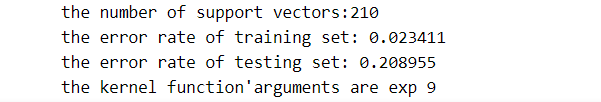  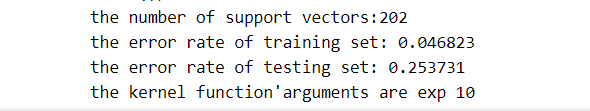

In [17]:
svmtest(('lap',10))

全样本遍历，第0次迭代 样本:0, alpha优化次数:1
全样本遍历，第0次迭代 样本:1, alpha优化次数:2
全样本遍历，第0次迭代 样本:2, alpha优化次数:3
全样本遍历，第0次迭代 样本:3, alpha优化次数:4
全样本遍历，第0次迭代 样本:4, alpha优化次数:5
全样本遍历，第0次迭代 样本:5, alpha优化次数:6
全样本遍历，第0次迭代 样本:6, alpha优化次数:7
全样本遍历，第0次迭代 样本:7, alpha优化次数:8
全样本遍历，第0次迭代 样本:8, alpha优化次数:9
全样本遍历，第0次迭代 样本:9, alpha优化次数:10
全样本遍历，第0次迭代 样本:10, alpha优化次数:11
全样本遍历，第0次迭代 样本:11, alpha优化次数:12
全样本遍历，第0次迭代 样本:12, alpha优化次数:12
全样本遍历，第0次迭代 样本:13, alpha优化次数:13
全样本遍历，第0次迭代 样本:14, alpha优化次数:14
全样本遍历，第0次迭代 样本:15, alpha优化次数:15
全样本遍历，第0次迭代 样本:16, alpha优化次数:16
全样本遍历，第0次迭代 样本:17, alpha优化次数:17
全样本遍历，第0次迭代 样本:18, alpha优化次数:18
全样本遍历，第0次迭代 样本:19, alpha优化次数:19
全样本遍历，第0次迭代 样本:20, alpha优化次数:20
全样本遍历，第0次迭代 样本:21, alpha优化次数:21
全样本遍历，第0次迭代 样本:22, alpha优化次数:22
全样本遍历，第0次迭代 样本:23, alpha优化次数:23
全样本遍历，第0次迭代 样本:24, alpha优化次数:24
全样本遍历，第0次迭代 样本:25, alpha优化次数:24
全样本遍历，第0次迭代 样本:26, alpha优化次数:25
全样本遍历，第0次迭代 样本:27, alpha优化次数:26
全样本遍历，第0次迭代 样本:28, alpha优化次数:27
全样本遍历，第0次迭代 样本:29, alpha优化次数:28
全样本遍历，第0次迭代 样本:30, alpha优化次数:29
全样本遍历，第0次迭代 样本:31, alpha优化次

全样本遍历，第0次迭代 样本:283, alpha优化次数:207
alpha_j变化太小
全样本遍历，第0次迭代 样本:284, alpha优化次数:207
全样本遍历，第0次迭代 样本:285, alpha优化次数:208
全样本遍历，第0次迭代 样本:286, alpha优化次数:208
全样本遍历，第0次迭代 样本:287, alpha优化次数:208
全样本遍历，第0次迭代 样本:288, alpha优化次数:208
全样本遍历，第0次迭代 样本:289, alpha优化次数:208
全样本遍历，第0次迭代 样本:290, alpha优化次数:209
全样本遍历，第0次迭代 样本:291, alpha优化次数:210
全样本遍历，第0次迭代 样本:292, alpha优化次数:211
全样本遍历，第0次迭代 样本:293, alpha优化次数:211
全样本遍历，第0次迭代 样本:294, alpha优化次数:212
全样本遍历，第0次迭代 样本:295, alpha优化次数:213
全样本遍历，第0次迭代 样本:296, alpha优化次数:214
全样本遍历，第0次迭代 样本:297, alpha优化次数:215
全样本遍历，第0次迭代 样本:298, alpha优化次数:216
迭代次数: 1
非边界遍历，第1次迭代 样本:0, alpha优化次数:1
非边界遍历，第1次迭代 样本:1, alpha优化次数:2
非边界遍历，第1次迭代 样本:2, alpha优化次数:3
非边界遍历，第1次迭代 样本:4, alpha优化次数:4
非边界遍历，第1次迭代 样本:5, alpha优化次数:5
非边界遍历，第1次迭代 样本:6, alpha优化次数:6
非边界遍历，第1次迭代 样本:7, alpha优化次数:7
非边界遍历，第1次迭代 样本:8, alpha优化次数:8
非边界遍历，第1次迭代 样本:9, alpha优化次数:9
非边界遍历，第1次迭代 样本:10, alpha优化次数:10
非边界遍历，第1次迭代 样本:11, alpha优化次数:11
非边界遍历，第1次迭代 样本:13, alpha优化次数:12
非边界遍历，第1次迭代 样本:14, alpha优化次数:13
非边界遍历，第1次迭代 样本:15, alpha优化次数:14
非边界遍历，

alpha_j变化太小
非边界遍历，第1次迭代 样本:274, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:275, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:276, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:278, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:279, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:280, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:282, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:283, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:285, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:290, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:291, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:292, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:294, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:295, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:296, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:297, alpha优化次数:48
alpha_j变化太小
非边界遍历，第1次迭代 样本:298, alpha优化次数:48
迭代次数: 2
alpha_j变化太小
非边界遍历，第2次迭代 样本:0, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:1, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:4, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:5, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:6, alpha优化次数:0
alpha_j变化太小
非边界遍历

alpha_j变化太小
非边界遍历，第2次迭代 样本:264, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:265, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:266, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:267, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:268, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:269, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:270, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:272, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:273, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:274, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:275, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:276, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:278, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:279, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:280, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:282, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:283, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:285, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:290, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:291, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:292, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:294, alpha优化次数:0
alpha_j变化太小
非边界遍历，第2次迭代 样本:295, 

alpha_j变化太小
全样本遍历，第3次迭代 样本:178, alpha优化次数:6
alpha_j变化太小
全样本遍历，第3次迭代 样本:179, alpha优化次数:6
alpha_j变化太小
全样本遍历，第3次迭代 样本:180, alpha优化次数:6
alpha_j变化太小
全样本遍历，第3次迭代 样本:181, alpha优化次数:6
全样本遍历，第3次迭代 样本:182, alpha优化次数:6
L==H
全样本遍历，第3次迭代 样本:183, alpha优化次数:6
L==H
全样本遍历，第3次迭代 样本:184, alpha优化次数:6
L==H
全样本遍历，第3次迭代 样本:185, alpha优化次数:6
全样本遍历，第3次迭代 样本:186, alpha优化次数:7
全样本遍历，第3次迭代 样本:187, alpha优化次数:7
全样本遍历，第3次迭代 样本:188, alpha优化次数:7
alpha_j变化太小
全样本遍历，第3次迭代 样本:189, alpha优化次数:7
alpha_j变化太小
全样本遍历，第3次迭代 样本:190, alpha优化次数:7
alpha_j变化太小
全样本遍历，第3次迭代 样本:191, alpha优化次数:7
全样本遍历，第3次迭代 样本:192, alpha优化次数:8
全样本遍历，第3次迭代 样本:193, alpha优化次数:8
全样本遍历，第3次迭代 样本:194, alpha优化次数:8
全样本遍历，第3次迭代 样本:195, alpha优化次数:9
全样本遍历，第3次迭代 样本:196, alpha优化次数:10
全样本遍历，第3次迭代 样本:197, alpha优化次数:10
alpha_j变化太小
全样本遍历，第3次迭代 样本:198, alpha优化次数:10
alpha_j变化太小
全样本遍历，第3次迭代 样本:199, alpha优化次数:10
全样本遍历，第3次迭代 样本:200, alpha优化次数:11
alpha_j变化太小
全样本遍历，第3次迭代 样本:201, alpha优化次数:11
全样本遍历，第3次迭代 样本:202, alpha优化次数:11
alpha_j变化太小
全样本遍历，第3次迭代 样本:203, alpha优化次数:11
alpha_j变化太小
全

alpha_j变化太小
非边界遍历，第4次迭代 样本:143, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:145, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:146, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:147, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:150, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:151, alpha优化次数:0
非边界遍历，第4次迭代 样本:153, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:154, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:156, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:158, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:159, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:160, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:162, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:163, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:164, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:165, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:167, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:168, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:169, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:170, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:171, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:172, alpha优化次数:0
alpha_j变化太小
非边界遍历，第4次迭代 样本:173, alpha优化次数:0


alpha_j变化太小
全样本遍历，第5次迭代 样本:105, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:106, alpha优化次数:0
全样本遍历，第5次迭代 样本:107, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:108, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:109, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:110, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:111, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:112, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:113, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:114, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:115, alpha优化次数:0
全样本遍历，第5次迭代 样本:116, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:117, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:118, alpha优化次数:0
全样本遍历，第5次迭代 样本:119, alpha优化次数:0
全样本遍历，第5次迭代 样本:120, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:121, alpha优化次数:0
全样本遍历，第5次迭代 样本:122, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:123, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:124, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:125, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:126, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:127, alpha优化次数:0
alpha_j变化太小
全样本遍历，第5次迭代 样本:128, alpha优化次数:0
alph

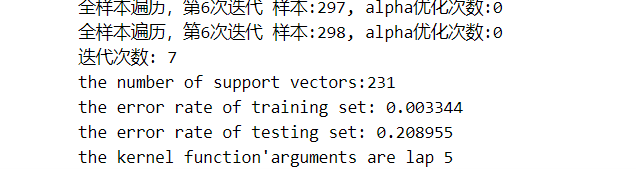

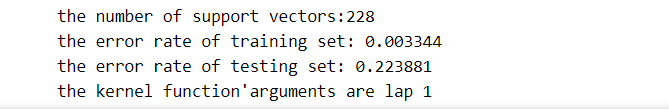